In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

## Class definition

In [2]:
class hh_neuron:
    
    def __init__(self, config={}):
        self.C = 1.
        self.g_Na = 120.
        self.g_K = 36.
        self.g_L = .3
        self.E_Na = 50.
        self.E_K = -77.
        self.E_L = -54.5
        self.I_ext = 10.
        self.I_syn = 0.
        self.tau_d = 3.
        self.tau_r = .1
        self.sim_n = 1
        self.m = []
        self.n = []
        self.h = []
        self.V = []
        
        if 'C' in config.keys():
            self.C = config['C']
        if 'g_Na' in config.keys():
            self.g_NA = config['g_Na']
        if 'g_K' in config.keys():
            self.g_K = config['g_K']
        if 'g_L' in config.keys():
            self.g_L = config['g_L']
        if 'E_Na' in config.keys():
            self.E_Na = config['E_Na']
        if 'E_K' in config.keys():
            self.E_K = config['E_K']
        if 'E_L' in config.keys():
            self.E_L = config['E_L']
        if 'I_ext' in config.keys():
            self.I_ext = config['I_ext']
        if 'I_syn' in config.keys():
            self.I_syn = config['I_syn']
        if 'tau_d' in config.keys():
            self.tau_d = config['tau_d']
        if 'tau_r' in config.keys():
            self.tau_r = config['tau_r']


    def alpha_m(self, V):
        """S5"""
        return .1 * (V + 40.) / (1. - np.exp(-(V + 40.) / 10.))

    def beta_m(self, V):
        """S6"""
        return 4. * np.exp(-(V + 65.) / 18.)

    def alpha_h(self, V):
        """S7"""
        return .07 * np.exp(-(V + 65.) / 20.)

    def beta_h(self, V):
        """S8"""
        return 1. / (1 + np.exp(-(V + 35.) / 10.))

    def alpha_n(self, V):
        """S9"""
        return ((V + 55.) / 100.) / (1. - np.exp((-.1) * (V + 55.)))

    def beta_n(self, V):
        """S10"""
        return .125 * np.exp(-(V + 65.) / 80.)

    def dm(self, V, m):
        """S2"""
        a = self.alpha_m(V)
        b = self.beta_m(V)

        return a * (1. - m) - b * m

    def dh(self, V, h):
        """S3"""
        a = self.alpha_h(V)
        b = self.beta_h(V)

        return a * (1. - h) - b * h

    def dn(self, V, n):
        """S4"""
        a = self.alpha_n(V)
        b = self.beta_n(V)

        return a * (1. - n) - b * n

    def dV(self, V, m, h, n):
        """S1"""
        return (- self.g_Na * m ** 3 * h * (V - self.E_Na) 
                - self.g_K * n ** 4 * (V - self.E_K) 
                - self.g_L * (V - self.E_L) 
                + self.I_ext + self.I_syn ) / self.C

## Configuration

In [3]:
hh_config = {
    'C': 1.,
    'g_Na': 120.,
    'g_K': 36.,
    'g_L': .3,
    'E_Na': 50.,
    'E_K': -77.,
    'E_L': -54.5,
    'I_ext': 10.
}

#tau_d = 3.
#tau_r = .1
#N = 500.

## Simulation

In [8]:
def simulate(neuron, start_time, end_time, step_size, V0):
    
    t = np.arange(start_time, end_time, step_size)
    
    m0 = np.random.rand()
    n0 = np.random.rand()
    h0 = np.random.rand()
    
    neuron.m = np.zeros(t.size)
    neuron.m[0] = m0
    neuron.h = np.zeros(t.size)
    neuron.h[0] = h0
    neuron.n = np.zeros(t.size)
    neuron.n[0] = n0 
    neuron.V = np.zeros(t.size)
    neuron.V[0] = V0
    
    # calculate new m, n, h and V
    for i in range(1, t.size):
    
        # intermediate
        m_i = neuron.m[i - 1] + step_size * neuron.dm(neuron.V[i - 1], neuron.m[i - 1])
        h_i = neuron.h[i - 1] + step_size * neuron.dh(neuron.V[i - 1], neuron.h[i - 1])
        n_i = neuron.n[i - 1] + step_size * neuron.dn(neuron.V[i - 1], neuron.n[i - 1])
        V_i = neuron.V[i - 1] + step_size * neuron.dV(neuron.V[i - 1], neuron.m[i], neuron.h[i], neuron.n[i])

        # heun
        neuron.m[i] = neuron.m[i - 1] + (step_size / 2.) * (neuron.dm(neuron.V[i - 1], neuron.m[i - 1]) + neuron.dm(V_i, m_i))
        neuron.h[i] = neuron.h[i - 1] + (step_size / 2.) * (neuron.dh(neuron.V[i - 1], neuron.h[i - 1]) + neuron.dh(V_i, h_i))
        neuron.n[i] = neuron.n[i - 1] + (step_size / 2.) * (neuron.dn(neuron.V[i - 1], neuron.n[i - 1]) + neuron.dn(V_i, n_i))
        neuron.V[i] = neuron.V[i - 1] + (step_size / 2.) * (neuron.dV(neuron.V[i - 1], neuron.m[i], neuron.h[i], neuron.n[i]) + neuron.dV(V_i, neuron.m[i], neuron.h[i], neuron.n[i]))

## Plotting

In [11]:
def plot_V(neuron):
    t = np.arange(0, len(neuron.V))
    plt.plot(t, neuron.V)
    plt.show()
    #plt.plot(t, neuron.m)
    #plt.plot(t, neuron.h)
    #plt.plot(t, neuron.n)
    #plt.legend(["m", "h", "n"])
    #plt.show()

# Experiment 1

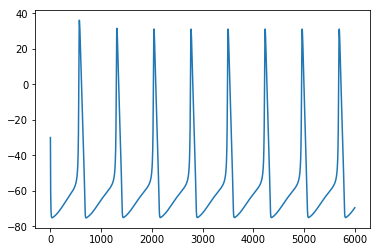

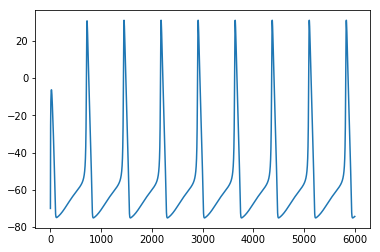

In [13]:
hh_1 = hh_neuron(hh_config)
simulate(hh_1, 0, 120, 0.02, -30)
plot_V(hh_1)

hh_2 = hh_neuron(hh_config)
simulate(hh_2, 0, 120, 0.02, -70)
plot_V(hh_2)